In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [29]:
device = 'cuda:2'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [30]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [31]:
# data = conf.make_dataset()
# batch = data[10]['img'][None]

In [48]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[0]['img'][None]

In [63]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


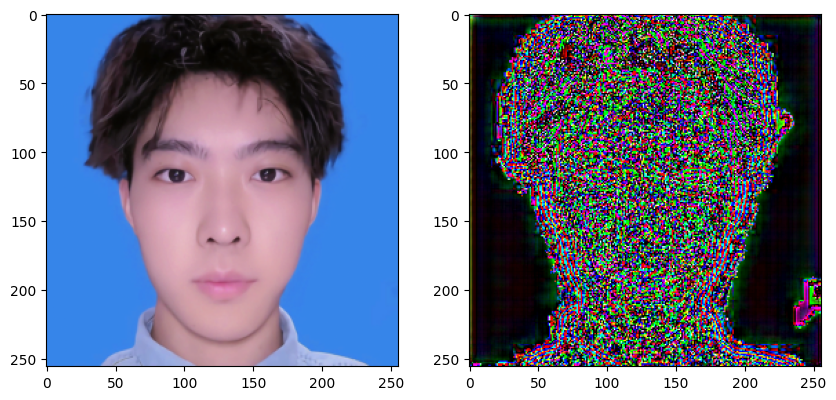

In [64]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [65]:
print(CelebAttrDataset.id_to_cls)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [88]:
cls_id = CelebAttrDataset.cls_to_id['Wearing_Hat']

In [89]:
cond2 = cls_model.normalize(cond)
cond2 = cond2 + 0.3 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cls_model.denormalize(cond2)

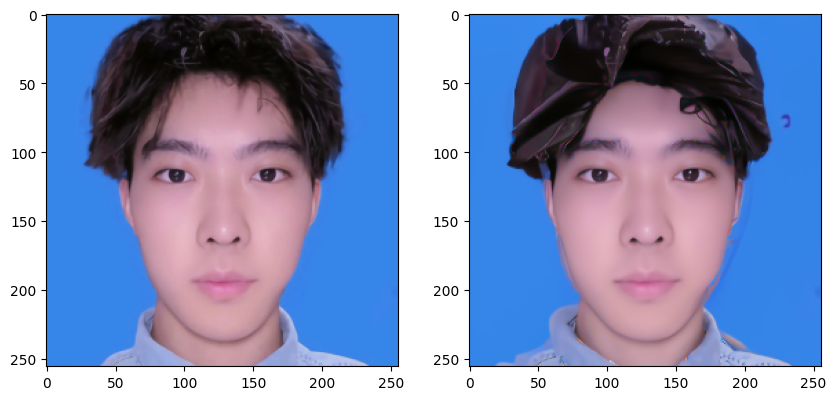

In [90]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

In [91]:
from torchvision.utils import *
save_image(img[0], 'imgs_manipulated/output.png')